# Summary

# Imports

In [1]:
import pyarrow

In [2]:
import concurrent.futures
import itertools
import multiprocessing
import os
import os.path as op
import pickle
import subprocess
import tempfile
from functools import partial
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import seaborn as sns
import sqlalchemy as sa
from scipy import stats
from sklearn import metrics

from kmtools import py_tools, sequence_tools

In [3]:
%matplotlib inline

In [4]:
pd.set_option("max_columns", 100)

# Parameters

In [5]:
NOTEBOOK_PATH = Path('validation_remote_homology_detection')
NOTEBOOK_PATH

PosixPath('validation_remote_homology_detection')

In [6]:
OUTPUT_PATH = Path(os.getenv('OUTPUT_DIR', NOTEBOOK_PATH.name)).resolve()
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
OUTPUT_PATH

PosixPath('/scratch/strokach/datapkg/adjacency-net-v2/notebooks/validation_remote_homology_detection')

In [46]:
proc = subprocess.run(["git", "rev-parse", "--short", "HEAD"], stdout=subprocess.PIPE)
GIT_REV = proc.stdout.decode().strip()
GIT_REV

'b6ef652'

In [7]:
TASK_ID = os.getenv("SLURM_ARRAY_TASK_ID")
TASK_COUNT = os.getenv("ORIGINAL_ARRAY_TASK_COUNT") or os.getenv("SLURM_ARRAY_TASK_COUNT")
NETWORK_NAME = os.getenv("NETWORK_NAME", GIT_REV)

TASK_ID = int(TASK_ID) if TASK_ID is not None else None
TASK_COUNT = int(TASK_COUNT) if TASK_COUNT is not None else None

TASK_ID, TASK_COUNT

(None, None)

In [8]:
DEBUG = "CI" not in os.environ    
DEBUG

True

In [9]:
if DEBUG:
    NETWORK_NAME = "dcn_old_0,9c5a963"
else:
    assert NETWORK_NAME is not None

In [10]:
# if DEBUG:
#     %load_ext autoreload
#     %autoreload 2

# `DATAPKG`

In [11]:
DATAPKG = {}

In [12]:
DATAPKG['uniparc-domain-wstructure'] = (
    Path(os.environ['DATAPKG_OUTPUT_DIR'])
    .joinpath("uniparc-domain-wstructure", "master")
)

In [13]:
DATAPKG['adjacency_net_v2'] = (
    Path(os.environ['DATAPKG_OUTPUT_DIR'])
    .joinpath("adjacency-net-v2", "master")
)

In [14]:
DATAPKG['hhsuite-wstructure'] = (
    Path(os.environ['DATAPKG_OUTPUT_DIR'])
    .joinpath("hhsuite-wstructure", "master")
)

# Network evaluation

In [15]:
%run trained_networks.ipynb

In [16]:
def predict_with_dcn_old(input_, network_info, network_state):
    from pagnn.prediction.dcn_old import Args, main
    for adj_col in ['adjacency_idx_1', 'adjacency_idx_2']:
        input_[adj_col] = input_.apply(lambda row: np.r_[row[adj_col], 0:len(row['sequence'])], axis=1).values
    args = Args(network_info=network_info, network_state=network_state)
    output_df = main(args, input_)
    return output_df

In [17]:
def predict_with_dcn(input_, network_info, network_state):
    from pagnn.prediction.dcn import Args, main
    args = Args(network_info=network_info, network_state=network_state)
    output_df = main(args, input_)
    return output_df

## Remote homology detection

In [18]:
remote_homology_dataset_file = (
    DATAPKG['hhsuite-wstructure']
    .joinpath('scop_remote_homology_detection', 'remote_homology_dataset.parquet')
)

In [19]:
remote_homology_dataset = pq.read_table(remote_homology_dataset_file).to_pandas()

In [20]:
display(remote_homology_dataset.head(2))
print(len(remote_homology_dataset))

,ali_confidence,aligned_cols,evalue,identity,probability,query_ali,query_end,query_id,query_length,query_neff,query_ss_pred,query_start,score,similarity,sum_probs,template_ali,template_end,template_id,template_info,template_length,template_neff,template_ss_dssp,template_ss_pred,template_start,scop_domain,unique_id,query_match_length,template_match_length,identity_calc,coverage_calc,scop_domain_canonical,a2b,b2a,sequence,adjacency_idx_1,adjacency_idx_2
0,45556666666655555566677789999999985,35,6.700000e-02,0.11,75.68,TLHLAVNYIDRFLSSMSVLRGKLQLVGTAAMLLAS,71,140209781,106,9.5,,37,26.67,0.118,24.5,IFIQIAELLDLCVLDVDCLEFPYGILAASALYHFS,66,d1w98b1,>d1w98b1 a.74.1.1 (B:228-357) G1/S-specific cy...,35,8.6,,,32,a.74.1.1,140209781-37:71-d1w98b1-32:66,35,35,0.114286,0.330189,a.74.1.1,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",IFIQIAELLDLCVLDVDCLEFPYGILAASALYHFS,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, ...","[1, 2, 3, 4, 30, 33, 34, 0, 2, 3, 4, 5, 30, 0,..."
1,45688999999999999999999999999999852 5799...,61,4.600000e-13,0.20,98.74,QVTIPKDLARSIIGKGGQRIKQIRHESGASIKIDEPLEGSEDRIIT...,74,182362022,79,9.5,,7,68.02,0.291,54.5,SQNHLKRIKGRIIGEGGRARRTIEEMTDTYINVGE-------YEVA...,76,d1tuaa2,>d1tuaa2 d.51.1.1 (A:85-188) Hypothetical prot...,61,7.4,,,16,d.51.1.1,182362022-7:74-d1tuaa2-16:76,68,61,0.176471,0.860759,d.51.1.1,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",SQNHLKRIKGRIIGEGGRARRTIEEMTDTYINVGEYEVAIIGDYER...,"[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 2, 36, 37, 38, 39, 0, 2, 3, 35, 36, 37, 38..."


3768


In [21]:
remote_homology_dataset['adjacency_coverage_1'] = (
    remote_homology_dataset['adjacency_idx_1'].apply(lambda l: len(set(l))) /
    remote_homology_dataset['sequence'].str.len()
)


remote_homology_dataset['adjacency_coverage_2'] = (
    remote_homology_dataset['adjacency_idx_2'].apply(lambda l: len(set(l))) /
    remote_homology_dataset['sequence'].str.len()
)

In [22]:
def validate_adjacency_df(adjacency_df):
    assert (adjacency_df['adjacency_idx_1'].apply(min) >= 0).all()
    assert (adjacency_df['adjacency_idx_2'].apply(min) >= 0).all()
    
    assert (
        adjacency_df['adjacency_idx_1'].apply(max) <
        adjacency_df['sequence'].str.len()
    ).all()

    assert (
        adjacency_df['adjacency_idx_2'].apply(max) <
        adjacency_df['sequence'].str.len()
    ).all()

    
validate_adjacency_df(remote_homology_dataset)

### Make predictions

In [23]:
for network_name in NETWORK_NAME.split(','):
    predict_with_network = predict_with_dcn_old if 'dcn_old' in network_name else predict_with_dcn
    remote_homology_dataset[network_name] = (
        predict_with_network(
            remote_homology_dataset.copy(),
            network_state=TRAINED_NETWORKS[network_name]['network_state'],
            network_info=TRAINED_NETWORKS[network_name]['network_info'],
        )
    )

Network name: 'DCN_9c5a963'
Final output_channels: 256


### Filter

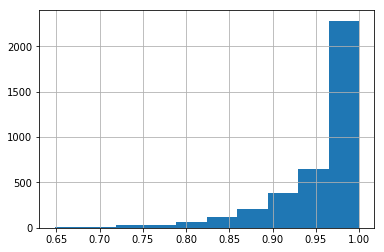

In [24]:
remote_homology_dataset['adjacency_coverage_1'].hist()

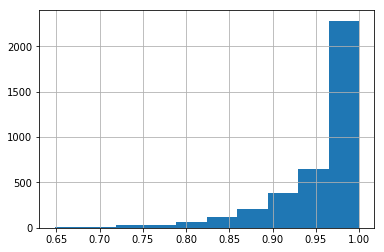

In [25]:
remote_homology_dataset['adjacency_coverage_2'].hist()

In [26]:
# remote_homology_dataset_filtered = (
#     remote_homology_dataset_df[
#         (remote_homology_dataset_df['adjacency_coverage_1'] > 0.8) &
#         (remote_homology_dataset_df['adjacency_coverage_2'] > 0.8)
#     ]
# ).copy()

In [27]:
# remote_homology_dataset_filtered = remote_homology_dataset.copy()

In [28]:
query_ids_w3plus = {
    query_id
    for query_id, group in 
        remote_homology_dataset
        .dropna(subset=NETWORK_NAME.split(','))
        .groupby('query_id')
    if len(group) >= 3
}

remote_homology_dataset_filtered = (
    remote_homology_dataset[
        remote_homology_dataset['query_id'].isin(query_ids_w3plus)
    ]
    .dropna(subset=NETWORK_NAME.split(','))
    .copy()
)

print(len(remote_homology_dataset))
print(len(remote_homology_dataset_filtered))

3768
2662


### Make plots

In [29]:
features = (
    [
        "identity_calc",
        "coverage_calc", 
        "identity", "similarity",
        "score",  "probability", # "evalue",
        "sum_probs",
    ] + NETWORK_NAME.split(',')
)

In [30]:
for scop_level in [1, 2, 3, 4]:
    remote_homology_dataset_filtered[f'scop_domain_matches_l{scop_level}'] = (
        remote_homology_dataset_filtered.apply(
            lambda row: 
                '.'.join(row['scop_domain'].split('.')[:scop_level]) == 
                '.'.join(row['scop_domain_canonical'].split('.')[:scop_level]),
            axis=1,
        )
    )

#### `DATA_ALL`

In [31]:
DATA_ALL = {}
for scop_level in [1, 2, 3, 4]:
    df = remote_homology_dataset_filtered.dropna(subset=features).copy()
    data = []
#     if f'scop_domain_matches_l{scop_level + 1}' in df:
#         df = df[df[f'scop_domain_matches_l{scop_level + 1}'] == False]
#     if scop_level < 4:
#         df = df[df[f'scop_domain_matches_l4'] == False]

    for feature in features:
        corr, pvalue = stats.spearmanr(df[feature], df[f'scop_domain_matches_l{scop_level}'])
        auc = metrics.roc_auc_score(df[f'scop_domain_matches_l{scop_level}'], df[feature])
        data.append((feature, corr, pvalue, auc))
    out_df = pd.DataFrame(data, columns=['feature', 'correlation', 'pvalue', 'auc'])
    DATA_ALL[scop_level] = len(df['query_id'].drop_duplicates()), len(df), out_df

#### `DATA_GBQ`

In [32]:
DATA_GBQ = {}

num_skips_small = {1: 0, 2: 0, 3: 0, 4: 0}
num_skips_eq = {1: 0, 2: 0, 3: 0, 4: 0}
num_skips_neq = {1: 0, 2: 0, 3: 0, 4: 0}

for scop_level in [1, 2, 3, 4]:
    df = remote_homology_dataset_filtered.dropna(subset=features).copy()
#     if f'scop_domain_matches_l{scop_level + 1}' in df:
#         df = df[df[f'scop_domain_matches_l{scop_level + 1}'] == False]
#     if scop_level < 4:
#         df = df[df[f'scop_domain_matches_l4'] == False]

    data = {f: {'corrs': [], 'pvalues': [], 'aucs': []} for f in features}
    count_groups = 0
    count_rows = 0
    for query_id, group in df.groupby('query_id'):
        if len(group) < 3:
            num_skips_small[scop_level] += 1
            continue
        elif (group[f'scop_domain_matches_l{scop_level}'] == True).all():
            num_skips_eq[scop_level] += 1
            continue
        elif (group[f'scop_domain_matches_l{scop_level}'] == False).all():
            num_skips_neq[scop_level] += 1
            continue
        for feature in features:
            if len(group[feature].drop_duplicates()) == 1:
                print(f"Skipping '{feature}'")
                continue
            corr, pvalue = stats.spearmanr(group[feature], group[f'scop_domain_matches_l{scop_level}'])
            auc = metrics.roc_auc_score(group[f'scop_domain_matches_l{scop_level}'], group[feature])
            data[feature]['corrs'].append(corr)
            data[feature]['pvalues'].append(pvalue)
            data[feature]['aucs'].append(auc)
        count_groups += 1
        count_rows += len(group)
    data_list = [
        (k, np.mean(v['corrs']), np.mean(v['pvalues']), np.mean(v['aucs']))
        for k, v in data.items()
    ]
    out_df = pd.DataFrame(data_list, columns=['feature', 'correlation', 'pvalue', 'auc'])
    DATA_GBQ[scop_level] = count_groups, count_rows, out_df
    
print(num_skips_small)
print(num_skips_eq)
print(num_skips_neq)

Skipping 'identity'
{1: 0, 2: 0, 3: 0, 4: 0}
{1: 205, 2: 65, 3: 52, 4: 8}
{1: 50, 2: 265, 3: 305, 4: 385}


#### Plot

In [33]:
cmap = plt.cm.get_cmap('Set1', 10)

In [34]:
scop_levels = {
    1: "class",
    2: "fold",
    3: "superfamily",
    4: "family",
}

In [35]:
feature_names = {
    'identity_calc': 'identity (aln.)',
    'coverage_calc': 'coverage (aln.)',
}

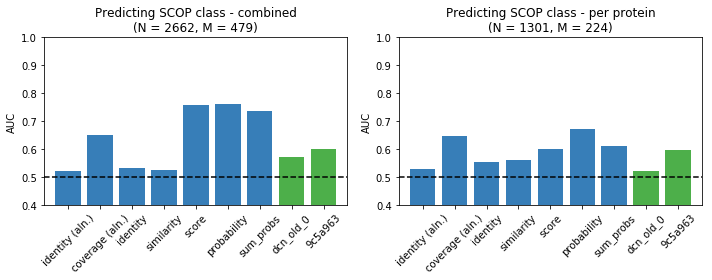

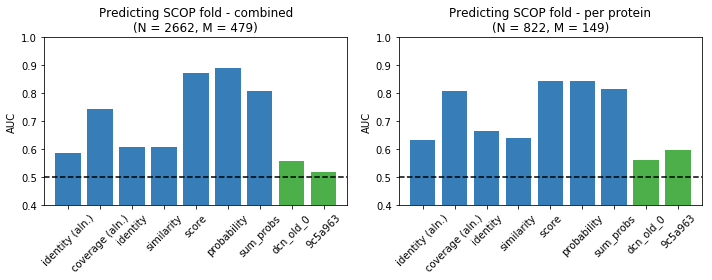

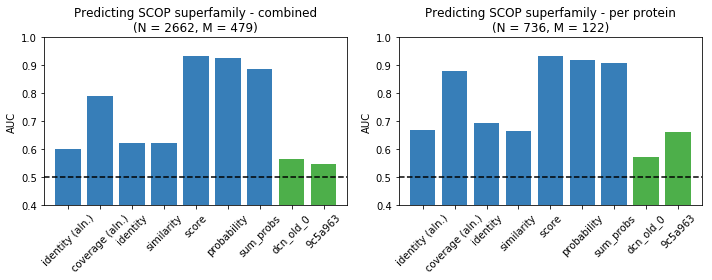

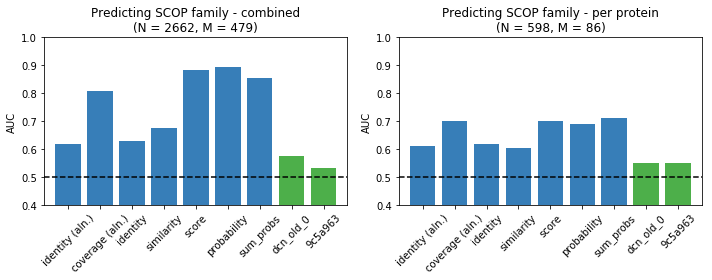

In [43]:
for scop_level in DATA_ALL:
    fg, axs = plt.subplots(1, 2, figsize=(10, 4))

    plt.sca(axs[0])
    num1, num2, df = DATA_ALL[scop_level]
    x = np.arange(len(df))
    c = [cmap(2) if f in NETWORK_NAME.split(',') else cmap(1) for f in df['feature']]
#     c = cmap(1)
    plt.bar(x, df['auc'].abs(), color=c)
    plt.xticks(x, [feature_names.get(f, f) for f in df['feature'].values], rotation=45)
    plt.ylim(0.4, 1)
    plt.ylabel("AUC")
    plt.title(
        f"Predicting SCOP {scop_levels[scop_level]} - combined\n"
        f"(N = {num2}, M = {num1})")
    plt.hlines(0.5, -0.75, len(features) - 0.25, linestyle='--')
    plt.ylim(0.4, 1)
    plt.xlim(-0.75, len(features) - 0.25)

    plt.sca(axs[1])
    num1, num2, df = DATA_GBQ[scop_level]
    x = np.arange(len(df))
    c = [cmap(2) if f in NETWORK_NAME.split(',') else cmap(1) for f in df['feature']]
#     c = cmap(1)
    plt.bar(x, df['auc'].abs(), color=c)
    plt.xticks(x, [feature_names.get(f, f) for f in df['feature'].values], rotation=45)
    plt.ylabel("AUC")
    plt.title(
        f"Predicting SCOP {scop_levels[scop_level]} - per protein\n"
        f"(N = {num2}, M = {num1})")
    plt.hlines(0.5, -0.75, len(features) - 0.25, linestyle='--')
    plt.ylim(0.4, 1)
    plt.xlim(-0.75, len(features) - 0.25)
    
    plt.tight_layout()
    plt.savefig(NOTEBOOK_PATH.joinpath(f"{NETWORK_NAME}_sl{scop_level}.png"), dpi=300, bbox_inches="tight")
    plt.savefig(NOTEBOOK_PATH.joinpath(f"{NETWORK_NAME}_sl{scop_level}.pdf"), bbox_inches="tight")